<a href="https://colab.research.google.com/github/GustavoSchroeder/ActiveMQ_Test/blob/master/Trabalho_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Decision Processes

In [7]:
!pip install gymnasium
!pip install gymnasium[toy_text]
import gymnasium as gym
import gymnasium.spaces as spaces
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import Image, display, clear_output
import io
import time
from IPython.display import Image, display
import random


## Trabalho Grau A

### MDP


Output()

Decisão: Início | Estado: Carros: 9, Pedestres: 2, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: 0
Decisão: Início | Estado: Carros: 9, Pedestres: 2, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: 0
Decisão: Início | Estado: Carros: 6, Pedestres: 3, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: 0
Decisão: Início | Estado: Carros: 4, Pedestres: 4, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: -2
Decisão: Início | Estado: Carros: 3, Pedestres: 5, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: -1
Decisão: Início | Estado: Carros: 2, Pedestres: 5, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: -1
Decisão: Início | Estado: Carros: 0, Pedestres: 5, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: -1
Decisão: Início | Estado: Carros: 0, Pedestres: 5, Ação: Fechar para Pedestre e Abrir para Carro, Recompensa: -1
Decisão: Início | Estado: Carros: 0, Pedestres: 5, Ação: Fechar para Pedestre e Abrir para Carro, R

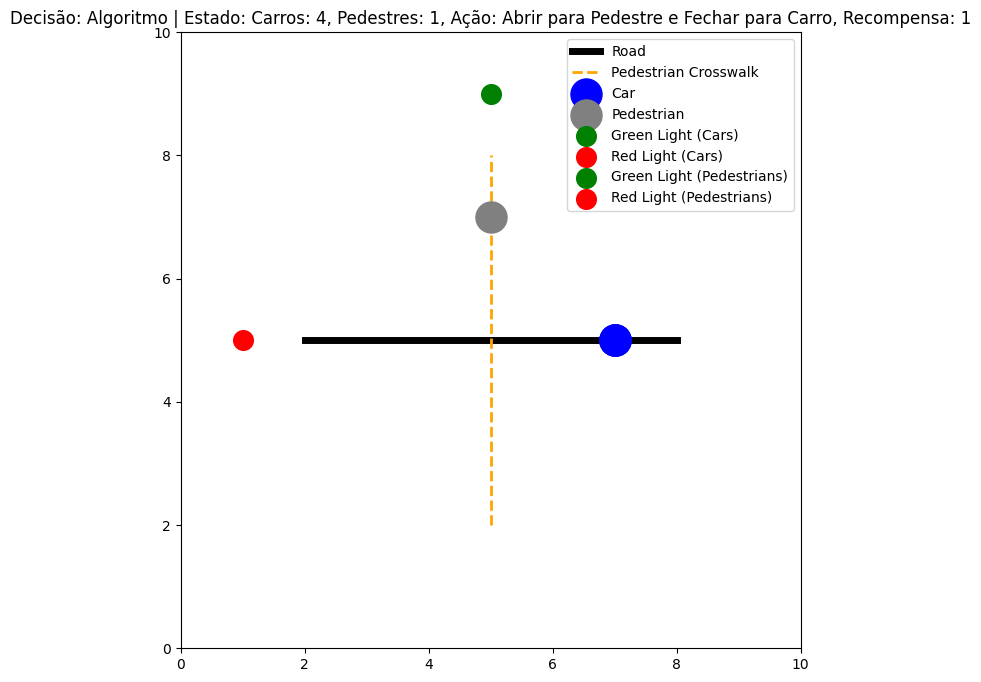

In [ ]:
class SmartTrafficLightEnv(gym.Env):
    def __init__(self):
        super(SmartTrafficLightEnv, self).__init__()

        # Espaço de ações: 0 -> Fechar para Pedestre e Abrir para Carro, 1 -> Abrir para Pedestre e Fechar para Carro
        self.action_space = spaces.Discrete(2)

        # Definir os limites para carros e pedestres
        self.car_limits = range(11)  # 0 a 10
        self.pedestrian_limits = range(6)  # 0 a 5

        # Criar todos os estados possíveis (combinações de carros e pedestres)
        self.states = [(cars, pedestrians) for cars in self.car_limits for pedestrians in self.pedestrian_limits]
        self.observation_space = spaces.Discrete(len(self.states))

        self.state = (0, 0)  # Estado inicial (0 carros, 0 pedestres)

        # Matriz de recompensas
        self.reward_matrix = {
            (0, 0): 1,
            (0, 1): 0,
            (1, 0): 1,
            (1, 1): -1,
            (2, 0): 0,
            (2, 1): 1,
            (3, 0): 0,
            (3, 1): 0
        }

        # Mecanismo de tempo: um contador para trocar as luzes após X passos
        self.time_counter = 0
        self.time_limit = 10

        # Ação padrão
        self.current_action = 0
        self.prev_state = self.state
        self.prev_action = 0

        # Variável para armazenar a razão da ação
        self.action_reason = ""

        # Variáveis para a fila média
        self.car_queue = []
        self.pedestrian_queue = []

        # Configuração inicial da figura
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_xlim(0, 10)
        self.ax.set_ylim(0, 10)
        self.setup_static_elements()

        # Widget de saída para visualização
        self.image_output = widgets.Output()
        display(self.image_output)

    def setup_static_elements(self):
        self.ax.plot([2, 8], [5, 5], color='black', linewidth=5, label='Road')
        self.ax.plot([5, 5], [2, 8], color='orange', linewidth=2, linestyle='--', label='Pedestrian Crosswalk')

        self.ax.scatter([], [], s=500, color='blue', label='Car', zorder=5)
        self.ax.scatter([], [], s=500, color='gray', label='Pedestrian', zorder=5)
        self.ax.scatter([], [], s=200, color='green', label='Green Light (Cars)', zorder=5)
        self.ax.scatter([], [], s=200, color='red', label='Red Light (Cars)', zorder=5)
        self.ax.scatter([], [], s=200, color='green', label='Green Light (Pedestrians)', zorder=5)
        self.ax.scatter([], [], s=200, color='red', label='Red Light (Pedestrians)', zorder=5)

        handles, labels = self.ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        self.ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    def reset(self):
        # Resete o estado com valores aleatórios de carros e pedestres
        cars = np.random.randint(0, 11)  # 0 a 10 carros
        pedestrians = np.random.randint(0, 6)  # 0 a 5 pedestres
        self.state = (cars, pedestrians)
        self.time_counter = 0
        self.current_action = 0
        self.action_reason = "Início"

        # Limpar as filas
        self.car_queue = []
        self.pedestrian_queue = []

        return self.states.index(self.state)  # Retorna o índice do estado

    def step(self):
        reward = 0
        self.prev_state = self.state
        self.prev_action = self.current_action

        # Armazenar o número de carros e pedestres na fila
        self.car_queue.append(self.state[0])
        self.pedestrian_queue.append(self.state[1])

        # Transição de estado com base na ação
        cars, pedestrians = self.state

        if self.current_action == 0:
            # Abrir para carros, diminuir o número de carros
            cars = max(0, cars - np.random.randint(1, 4))  # Reduz entre 1 e 3 carros
            pedestrians = min(5, pedestrians + np.random.randint(1, 3))  # Aumenta entre 1 e 2 pedestres
        else:
            # Abrir para pedestres, diminuir o número de pedestres
            pedestrians = max(0, pedestrians - np.random.randint(1, 3))  # Reduz entre 1 e 2 pedestres
            cars = min(10, cars + np.random.randint(1, 4))  # Aumenta entre 1 e 3 carros

        self.state = (cars, pedestrians)

        self.time_counter += 1

        if self.time_counter >= self.time_limit:
            # Calcular as médias das filas
            average_cars = np.mean(self.car_queue)
            average_pedestrians = np.mean(self.pedestrian_queue)

            # A lógica para calcular recompensas pode ser ajustada conforme necessário
            reward = self.calculate_reward(average_cars, average_pedestrians)

            # Logica para mudança de ação
            reward_if_switch = self.reward_matrix.get((self.states.index(self.state), 1 - self.current_action), 0)
            reward_if_stay = reward

            if reward_if_switch > reward_if_stay:
                self.current_action = 1 - self.current_action
                self.action_reason = "Algoritmo"
            else:
                self.action_reason = "Tempo"

            # Resetar contadores e filas
            self.time_counter = 0
            self.car_queue.clear()
            self.pedestrian_queue.clear()

        return self.states.index(self.prev_state), reward, False, {}

    def calculate_reward(self, average_cars, average_pedestrians):
        # Exemplo de cálculo de recompensa baseado nas filas médias
        reward = 0

        # Exemplo de lógica:
        if average_cars > 5:
            reward -= 1  # Penalizar se a média de carros for alta
        if average_pedestrians > 3:
            reward -= 1  # Penalizar se a média de pedestres for alta
        else:
            reward += 1  # Recompensar se a média de pedestres for baixa

        return reward

    def render(self, state_index, action):
        for collection in self.ax.collections:
            collection.remove()
        for img in self.ax.images:
            img.remove()
        for line in self.ax.lines[2:]:
            line.remove()

        state = self.states[state_index]
        cars, pedestrians = state

        states_description = f"Carros: {cars}, Pedestres: {pedestrians}"
        actions = ["Fechar para Pedestre e Abrir para Carro", "Abrir para Pedestre e Fechar para Carro"]

        # Adicionando a recompensa ao log
        decision_log = f"Decisão: {self.action_reason} | Estado: {states_description}, Ação: {actions[action]}, Recompensa: {self.calculate_reward(np.mean(self.car_queue), np.mean(self.pedestrian_queue))}"
        print(decision_log)  # Log no console
        self.ax.set_title(decision_log)

        # Atualizar posições dos carros e pedestres na visualização
        car_positions = [(7, 5)] * cars
        pedestrian_positions = [(5, 7)] * pedestrians

        for pos in car_positions:
            self.ax.scatter(pos[0], pos[1], s=500, color='blue', zorder=5)

        for pos in pedestrian_positions:
            self.ax.scatter(pos[0], pos[1], s=500, color='gray', zorder=5)

        if action == 0:
            self.ax.scatter(1, 5, s=200, color='green', zorder=5)
            self.ax.scatter(5, 9, s=200, color='red', zorder=5)
        else:
            self.ax.scatter(1, 5, s=200, color='red', zorder=5)
            self.ax.scatter(5, 9, s=200, color='green', zorder=5)

        buf = io.BytesIO()
        self.fig.savefig(buf, format='png')
        buf.seek(0)
        img = Image(data=buf.getvalue())

        with self.image_output:
            clear_output(wait=True)
            display(img)


# Inicializar o ambiente
env = SmartTrafficLightEnv()

# Loop de simulação
for episode in range(5):
    state = env.reset()
    for _ in range(15):  # Muda para um loop que itera 15 vezes
        action = env.current_action
        next_state, reward, done, info = env.step()
        env.render(state, action)
        time.sleep(0.2)
        state = next_state

env.close()

In [ ]:
### Programação Dinâmica

Policy Iteration

# Policy Iteration

In [ ]:
def policy_evaluation(env, policy, gamma, theta):
    V = np.zeros(env.observation_space.n)  # Inicializar a função de valor V(s) para todos os estados
    iteration = 1
    while True:
        delta = 0
        for state in range(env.observation_space.n):
            v = V[state]
            action = policy[state]
            env.state = env.states[state]  # Definir o estado atual no ambiente

            # Executar a ação selecionada pela política e observar a recompensa e o próximo estado
            next_state, reward, _, _ = env.step()
            V[state] = reward + gamma * V[next_state]
            delta = max(delta, abs(v - V[state]))  # Atualizar delta

        # Log para verificar a convergência
        # print(f"Iteration {iteration}: delta={delta}")
        iteration += 1

        if delta < theta:
            break
    return V

In [ ]:
def policy_improvement(env, V, gamma):
    policy = np.zeros(env.observation_space.n, dtype=int)  # Inicializar a política
    policy_stable = True

    for state in range(env.observation_space.n):
        old_action = policy[state]
        action_values = []

        for action in range(env.action_space.n):
            env.state = env.states[state]
            next_state, reward, _, _ = env.step()  # Executar ação no ambiente
            action_values.append(reward + gamma * V[next_state])

        best_action = np.argmax(action_values)
        policy[state] = best_action

        if old_action != best_action:
            policy_stable = False

    return policy, policy_stable

In [ ]:
def policy_iteration(env, gamma, theta):
    # Inicializar a política arbitrariamente
    policy = np.random.choice(env.action_space.n, size=env.observation_space.n)

    i = 0
    while True:
        i += 1
        print(f"Iteração: {i}")

        # Avaliar a política atual
        V = policy_evaluation(env, policy, gamma, theta)

        # Melhorar a política com base na função de valor V(s)
        policy, policy_stable = policy_improvement(env, V, gamma)

        # Se a política não mudou, o algoritmo termina
        if policy_stable:
            break

    return policy, V

Output()

Iteração: 1
Iteração: 2
Iteração: 3
Iteração: 4
Iteração: 5
Iteração: 6
Iteração: 7
Iteração: 8
Iteração: 9
Iteração: 10
Iteração: 11
Iteração: 12
Iteração: 13
Iteração: 14
Iteração: 15
Iteração: 16
Iteração: 17
Iteração: 18
Iteração: 19
Iteração: 20
Iteração: 21
Iteração: 22
Iteração: 23
Iteração: 24
Iteração: 25
Iteração: 26
Iteração: 27
Iteração: 28
Iteração: 29
Iteração: 30
Iteração: 31
Iteração: 32
Iteração: 33
Iteração: 34
Iteração: 35
Iteração: 36
Iteração: 37
Iteração: 38
Iteração: 39
Iteração: 40
Iteração: 41
Iteração: 42
Iteração: 43
Iteração: 44
Iteração: 45
Iteração: 46
Iteração: 47
Iteração: 48
Iteração: 49
Iteração: 50
Iteração: 51
Iteração: 52
Iteração: 53
Iteração: 54
Iteração: 55
Iteração: 56
Iteração: 57
Iteração: 58
Iteração: 59
Iteração: 60
Iteração: 61
Iteração: 62
Iteração: 63
Iteração: 64
Iteração: 65
Iteração: 66
Iteração: 67
Iteração: 68
Iteração: 69
Iteração: 70
Iteração: 71
Iteração: 72
Iteração: 73
Iteração: 74
Iteração: 75
Iteração: 76
Iteração: 77
Iteração

KeyboardInterrupt: 

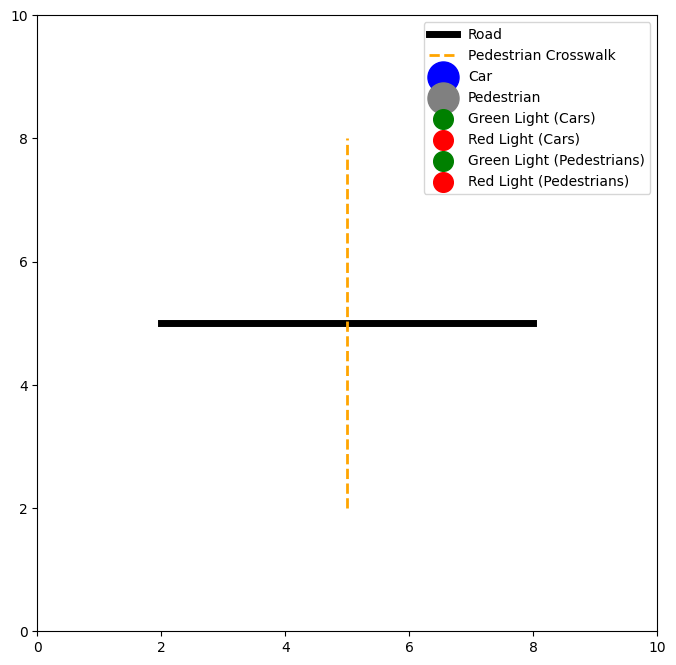

In [ ]:
# Teste

env = SmartTrafficLightEnv()
gamma = 0.9
theta = 0.84

optimal_policy, optimal_value_function = policy_iteration(env, gamma, theta)

# Exibir a política ótima
print("Política Ótima:")
for state in range(env.observation_space.n):
    cars, pedestrians = env.states[state]
    print(f"Estado (Carros: {cars}, Pedestres: {pedestrians}): Ação {optimal_policy[state]}")

# Exibir a função de valor ótima
print("\nFunção de Valor Ótima:")
for state in range(env.observation_space.n):
    cars, pedestrians = env.states[state]
    print(f"Estado (Carros: {cars}, Pedestres: {pedestrians}): Valor {optimal_value_function[state]:.2f}")

# Diferença Temporal - Q-Learning

Nesse caso quis fazer como agente, então usei como base essa implementação:

https://github.com/nokia/wireless-suite/blob/79385850eabadb5d2a4fdb7263a33b5c25c91e98/wireless/agents/q_learning.py

In [49]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Inicializar a tabela Q
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        # Escolher uma ação usando a estratégia ε-greedy
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))  # Exploração
        else:
            return np.argmax(self.q_table[state])  # Exploração

    def learn(self, state, action, reward, next_state):
        # Atualizar a tabela Q
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_delta

    def decay_epsilon(self):
        # Decair o valor de ε
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def print_metrics(self):
        print("\nTabela Q final:")
        print(self.q_table)
        print(f"Epsilon final: {self.epsilon:.4f}")

    def run_optimal_policy(self, env, num_steps=15):
        state = env.reset()
        state_index = state
        total_reward = 0

        print("\nExecutando a política ótima:")
        for _ in range(num_steps):
            action = np.argmax(self.q_table[state_index])  # Ação com o maior valor Q
            next_state_index, reward, done, info = env.step(action)
            env.render(state_index, action)
            time.sleep(1)

            state_index = next_state_index
            total_reward += reward

        print(f"Recompensa total na política ótima: {total_reward}")


Output()

Episódio 1: Recompensa total = 0 (0)
Episódio 2: Recompensa total = -2 (0)
Episódio 3: Recompensa total = -2 (0)
Episódio 4: Recompensa total = -2 (0)
Episódio 5: Recompensa total = -3 (0)
Episódio 6: Recompensa total = -3 (0)
Episódio 7: Recompensa total = -4 (0)
Episódio 8: Recompensa total = -4 (0)
Episódio 9: Recompensa total = -5 (0)
Episódio 10: Recompensa total = -6 (0)
Episódio 11: Recompensa total = -7 (0)
Episódio 12: Recompensa total = -8 (0)
Episódio 13: Recompensa total = -7 (0)
Episódio 14: Recompensa total = -9 (0)
Episódio 15: Recompensa total = -10 (0)
Episódio 16: Recompensa total = -11 (0)
Episódio 17: Recompensa total = -10 (0)
Episódio 18: Recompensa total = -12 (0)
Episódio 19: Recompensa total = -11 (0)
Episódio 20: Recompensa total = -10 (0)
Episódio 21: Recompensa total = -11 (0)
Episódio 22: Recompensa total = -10 (0)
Episódio 23: Recompensa total = -10 (0)
Episódio 24: Recompensa total = -10 (0)
Episódio 25: Recompensa total = -10 (0)
Episódio 26: Recompensa 

Output()


Executando a política ótima:


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Recompensa total na política ótima: 0


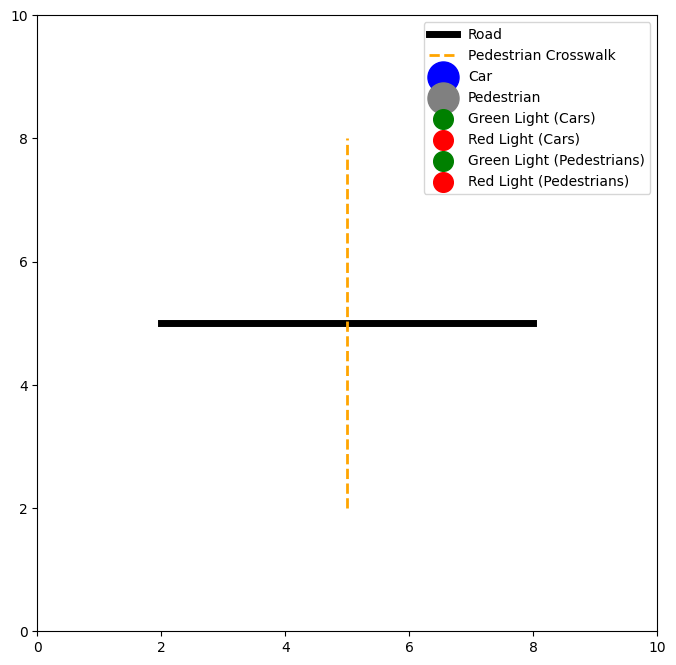

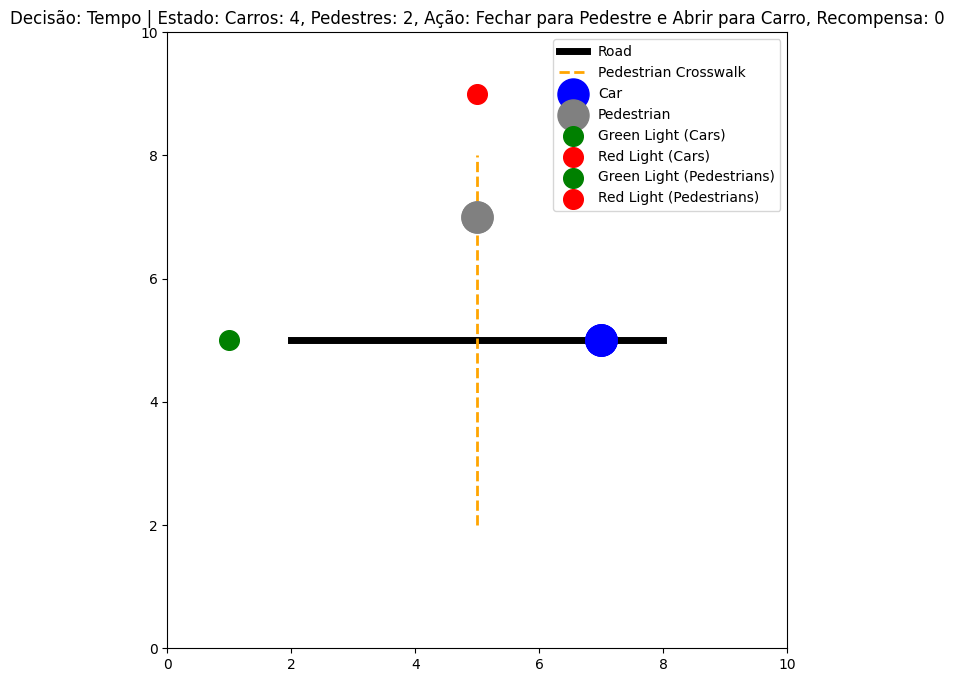

In [50]:
class SmartTrafficLightEnv(gym.Env):
    def __init__(self, show_render=False):  # Adicionando o parâmetro show_render
        super(SmartTrafficLightEnv, self).__init__()

        # Espaço de ações: 0 -> Fechar para Pedestre e Abrir para Carro, 1 -> Abrir para Pedestre e Fechar para Carro
        self.action_space = spaces.Discrete(2)

        # Definir os limites para carros e pedestres
        self.car_limits = range(11)  # 0 a 10
        self.pedestrian_limits = range(6)  # 0 a 5

        # Criar todos os estados possíveis (combinações de carros e pedestres)
        self.states = [(cars, pedestrians) for cars in self.car_limits for pedestrians in self.pedestrian_limits]
        self.observation_space = spaces.Discrete(len(self.states))

        self.state = (0, 0)  # Estado inicial (0 carros, 0 pedestres)

        # Matriz de recompensas
        self.reward_matrix = {
            (0, 0): 1,
            (0, 1): 0,
            (1, 0): 1,
            (1, 1): -1,
            (2, 0): 0,
            (2, 1): 1,
            (3, 0): 0,
            (3, 1): 0
        }

        # Mecanismo de tempo: um contador para trocar as luzes após X passos
        self.time_counter = 0
        self.time_limit = 10

        # Ação padrão
        self.current_action = 0
        self.prev_state = self.state
        self.prev_action = 0

        # Variável para armazenar a razão da ação
        self.action_reason = ""

        # Variáveis para a fila média
        self.car_queue = []
        self.pedestrian_queue = []

        # Definir se o gráfico deve ser exibido ou não
        self.show_render = show_render

        # Configuração inicial da figura
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_xlim(0, 10)
        self.ax.set_ylim(0, 10)
        self.setup_static_elements()

        # Widget de saída para visualização
        self.image_output = widgets.Output()
        display(self.image_output)

    def setup_static_elements(self):
        self.ax.plot([2, 8], [5, 5], color='black', linewidth=5, label='Road')
        self.ax.plot([5, 5], [2, 8], color='orange', linewidth=2, linestyle='--', label='Pedestrian Crosswalk')

        self.ax.scatter([], [], s=500, color='blue', label='Car', zorder=5)
        self.ax.scatter([], [], s=500, color='gray', label='Pedestrian', zorder=5)
        self.ax.scatter([], [], s=200, color='green', label='Green Light (Cars)', zorder=5)
        self.ax.scatter([], [], s=200, color='red', label='Red Light (Cars)', zorder=5)
        self.ax.scatter([], [], s=200, color='green', label='Green Light (Pedestrians)', zorder=5)
        self.ax.scatter([], [], s=200, color='red', label='Red Light (Pedestrians)', zorder=5)

        handles, labels = self.ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        self.ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    def reset(self):
        # Resete o estado com valores aleatórios de carros e pedestres
        cars = np.random.randint(0, 11)  # 0 a 10 carros
        pedestrians = np.random.randint(0, 6)  # 0 a 5 pedestres
        self.state = (cars, pedestrians)
        self.time_counter = 0
        self.current_action = 0
        self.action_reason = "Início"

        # Limpar as filas
        self.car_queue = []
        self.pedestrian_queue = []

        return self.states.index(self.state)  # Retorna o índice do estado

    def step(self, action):
      reward = 0
      self.prev_state = self.state
      self.prev_action = self.current_action
      self.current_action = action  # A ação agora é recebida como argumento

      # Armazenar o número de carros e pedestres na fila
      self.car_queue.append(self.state[0])
      self.pedestrian_queue.append(self.state[1])

      # Transição de estado com base na ação
      cars, pedestrians = self.state

      if self.current_action == 0:
          # Abrir para carros, diminuir o número de carros
          cars = max(0, cars - np.random.randint(1, 4))  # Reduz entre 1 e 3 carros
          pedestrians = min(5, pedestrians + np.random.randint(1, 3))  # Aumenta entre 1 e 2 pedestres
      else:
          # Abrir para pedestres, diminuir o número de pedestres
          pedestrians = max(0, pedestrians - np.random.randint(1, 3))  # Reduz entre 1 e 2 pedestres
          cars = min(10, cars + np.random.randint(1, 4))  # Aumenta entre 1 e 3 carros

      self.state = (cars, pedestrians)

      self.time_counter += 1

      if self.time_counter >= self.time_limit:
          # Calcular as médias das filas
          average_cars = np.mean(self.car_queue)
          average_pedestrians = np.mean(self.pedestrian_queue)

          # A lógica para calcular recompensas pode ser ajustada conforme necessário
          reward = self.calculate_reward(average_cars, average_pedestrians)

          # Lógica para mudança de ação
          reward_if_switch = self.reward_matrix.get((self.states.index(self.state), 1 - self.current_action), 0)
          reward_if_stay = reward

          if reward_if_switch > reward_if_stay:
              self.current_action = 1 - self.current_action
              self.action_reason = "Algoritmo"
          else:
              self.action_reason = "Tempo"

          # Resetar contadores e filas
          self.time_counter = 0
          self.car_queue.clear()
          self.pedestrian_queue.clear()

      return self.states.index(self.prev_state), reward, False, {}


    def calculate_reward(self, average_cars, average_pedestrians):
        # Exemplo de cálculo de recompensa baseado nas filas médias
        reward = 0

        # Exemplo de lógica:
        if average_cars > 5:
            reward -= 1  # Penalizar se a média de carros for alta
        if average_pedestrians > 3:
            reward -= 1  # Penalizar se a média de pedestres for alta
        else:
            reward += 1  # Recompensar se a média de pedestres for baixa

        return reward

    def render(self, state_index, action):
        if not self.show_render:
            return  # Se o show_render for False, não faz o render

        for collection in self.ax.collections:
            collection.remove()
        for img in self.ax.images:
            img.remove()
        for line in self.ax.lines[2:]:
            line.remove()

        state = self.states[state_index]
        cars, pedestrians = state

        states_description = f"Carros: {cars}, Pedestres: {pedestrians}"
        actions = ["Fechar para Pedestre e Abrir para Carro", "Abrir para Pedestre e Fechar para Carro"]

        # Adicionando a recompensa ao log
        decision_log = f"Decisão: {self.action_reason} | Estado: {states_description}, Ação: {actions[action]}, Recompensa: {self.calculate_reward(np.mean(self.car_queue), np.mean(self.pedestrian_queue))}"
        self.ax.set_title(decision_log)

        # Atualizar posições dos carros e pedestres na visualização
        car_positions = [(7, 5)] * cars
        pedestrian_positions = [(5, 7)] * pedestrians

        for pos in car_positions:
            self.ax.scatter(pos[0], pos[1], s=500, color='blue', zorder=5)

        for pos in pedestrian_positions:
            self.ax.scatter(pos[0], pos[1], s=500, color='gray', zorder=5)

        if action == 0:
            self.ax.scatter(1, 5, s=200, color='green', zorder=5)
            self.ax.scatter(5, 9, s=200, color='red', zorder=5)
        else:
            self.ax.scatter(1, 5, s=200, color='red', zorder=5)
            self.ax.scatter(5, 9, s=200, color='green', zorder=5)

        buf = io.BytesIO()
        self.fig.savefig(buf, format='png')
        buf.seek(0)
        img = Image(data=buf.getvalue())

        with self.image_output:
            clear_output(wait=True)
            display(img)

# Inicializar o ambiente para o treinamento (sem renderização)
env = SmartTrafficLightEnv(show_render=False)
agent = QLearningAgent(state_size=len(env.states), action_size=env.action_space.n)

total_reward = 0

rewards = []

# Loop de simulação
num_episodes = 300
rangeEpisodes = 15
for episode in range(num_episodes):
    state_index = env.reset()
    for _ in range(rangeEpisodes):  # Muda para um loop que itera x vezes
        action = agent.choose_action(state_index)  # Escolhe uma ação
        next_state_index, reward, done, info = env.step(action)  # Passa a ação corretamente

        # Aprender com a experiência
        agent.learn(state_index, action, reward, next_state_index)

        # Renderizar o ambiente (opcional, mas agora está desativado para treinamento)
        # env.render(state_index, action)
        #time.sleep(0.2)

        # Atualizar o estado atual
        state_index = next_state_index
        total_reward += reward
        rewards.append(total_reward)

    # Decair epsilon após cada episódio
    agent.decay_epsilon()
    print(f"Episódio {episode + 1}: Recompensa total = {total_reward} ({reward})")

# Executar a política ótima com renderização
optimal_env = SmartTrafficLightEnv(show_render=True)  # Ativar renderização para a política ótima
agent.run_optimal_policy(optimal_env, num_steps=15)

optimal_env.close()


Average reward (all episodes): -34.812
Average reward (last 100 episodes): -49.6
Total Episodes (Episodes / Range)range(0, 4500)
Total Rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -10

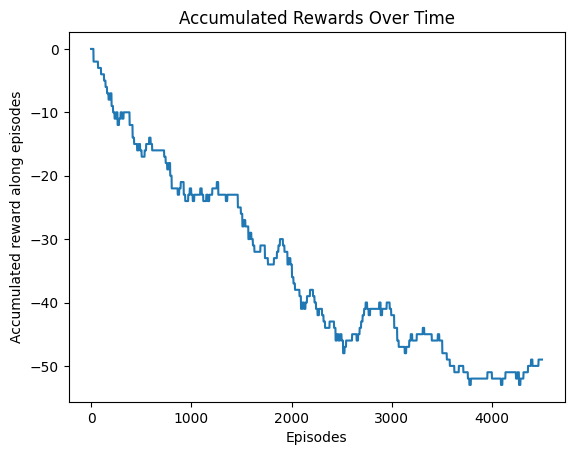

In [51]:
# Imprimir resultados

total_episodes = num_episodes * rangeEpisodes

print("Average reward (all episodes): " + str(sum(rewards)/total_episodes))
print("Average reward (last 100 episodes): " + str(sum(rewards[-100:])/100))

print("Total Episodes (Episodes / Range)" + str(range(total_episodes)))
print("Total Rewards: " + str(rewards))

range_rewards = len(rewards)

plt.plot(range(range_rewards), rewards)
plt.xlabel('Episodes')
plt.ylabel('Accumulated reward along episodes')
plt.title('Accumulated Rewards Over Time')
plt.show()